In [1]:
import numpy as np
import pandas as pd

In [2]:
import fastai
fastai.__version__

'1.0.57'

In [3]:
from fastai.text import *
from fastai.callbacks import *

In [4]:
data_train = pd.read_csv("clickbait-data/train.csv")
data_valid = pd.read_csv("clickbait-data/valid.csv")
data_test = pd.read_csv("clickbait-data/test.csv")

In [5]:
data_train.fillna("xxempty", inplace=True)
data_valid.fillna("xxempty", inplace=True)
data_test.fillna("xxempty", inplace=True)

In [6]:
data_train["full"] = data_train["text"].apply(lambda x: x + " xxtitle ") + data_train["title"]
data_valid["full"] = data_valid["text"].apply(lambda x: x + " xxtitle ") + data_valid["title"]
data_test["full"] = data_test["text"].apply(lambda x: x + " xxtitle ") + data_test["title"]

In [7]:
data_train["is_valid"] = False
data_valid["is_valid"] = True

In [9]:
data_lm = (TextList.from_df(pd.concat([data_train, data_valid]), cols=["full"])
           .split_from_df("is_valid")
           .label_for_lm()
           .databunch())

In [9]:
lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained=True)


In [10]:
lm.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 8.32E-03


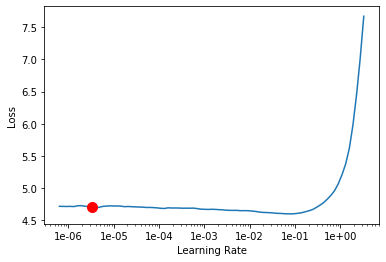

In [11]:
lm.recorder.plot(suggestion=True)


In [12]:
lm.fit_one_cycle(1, 4e-3, callbacks=[SaveModelCallback(lm, name="best_lm")], moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.000452,3.828324,0.330326,08:13


Better model found at epoch 0 with valid_loss value: 3.8283238410949707.


In [13]:
lm.unfreeze()


In [14]:
lm.fit_one_cycle(5, 4e-3, callbacks=[SaveModelCallback(lm, name="best_lm")], moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,3.852017,3.842271,0.333769,09:18
1,3.889559,3.814291,0.338045,09:18
2,3.678092,3.682595,0.353118,09:18
3,3.444768,3.574678,0.365831,09:17
4,3.275865,3.554439,0.368710,09:16


Better model found at epoch 0 with valid_loss value: 3.842271327972412.
Better model found at epoch 1 with valid_loss value: 3.814291477203369.
Better model found at epoch 2 with valid_loss value: 3.6825947761535645.
Better model found at epoch 3 with valid_loss value: 3.574678421020508.
Better model found at epoch 4 with valid_loss value: 3.554438829421997.


In [15]:
lm.load("best_lm")


LanguageLearner(data=TextLMDataBunch;

Train: LabelList (24871 items)
x: LMTextList
xxbos xxmaj economists generally agree : xxmaj china must overhaul its huge but wasteful economy if it wants to continue to grow in the years to come . xxmaj that means limiting political interference in banking and the financial system , making bloated industries more sensitive to market forces and lowering barriers against foreign trade and investment . xxmaj proponents took heart in late 2012 when xxmaj president xxmaj xi xxmaj jinping took formal control of the xxmaj chinese xxmaj communist xxmaj party with pledges to crack down on corruption and cut red tape . xxmaj today , as xxmaj mr. xxmaj xi nears the end of his first five - year term , much of the optimism among economists has faded . xxmaj china remains heavily dependent on large investments and has maintained brisk but slowing economic growth only with a steep rise in government - steered lending . xxmaj still , his administration has made s

In [16]:
lm.save_encoder("enc")


In [10]:
data_clf = (TextList.from_df(pd.concat([data_train, data_valid]), vocab=data_lm.vocab, cols=["full"]).
           split_from_df("is_valid").
           label_from_df("label").
           add_test(data_test["full"]).
           databunch()
          )

In [11]:
clf = text_classifier_learner(data_clf, AWD_LSTM, drop_mult=0.3)


In [ ]:
del lm
torch.cuda.empty_cache()

In [12]:
clf.load_encoder("enc")


RNNLearner(data=TextClasDataBunch;

Train: LabelList (24871 items)
x: TextList
xxbos xxmaj economists generally agree : xxmaj china must overhaul its huge but wasteful economy if it wants to continue to grow in the years to come . xxmaj that means limiting political interference in banking and the financial system , making bloated industries more sensitive to market forces and lowering barriers against foreign trade and investment . xxmaj proponents took heart in late 2012 when xxmaj president xxmaj xi xxmaj jinping took formal control of the xxmaj chinese xxmaj communist xxmaj party with pledges to crack down on corruption and cut red tape . xxmaj today , as xxmaj mr. xxmaj xi nears the end of his first five - year term , much of the optimism among economists has faded . xxmaj china remains heavily dependent on large investments and has maintained brisk but slowing economic growth only with a steep rise in government - steered lending . xxmaj still , his administration has made some s

In [21]:
clf.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


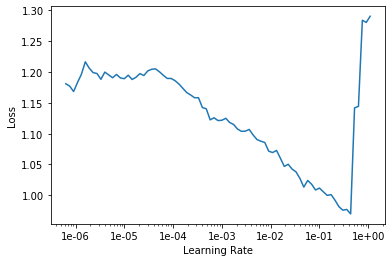

In [22]:
clf.recorder.plot()


In [23]:
clf.fit(3, 2e-3, callbacks=[SaveModelCallback(clf, name="best_clf")])

epoch,train_loss,valid_loss,accuracy,time
0,0.503328,0.300113,0.871622,02:39
1,0.446597,0.299941,0.876408,02:40
2,0.440614,0.327269,0.878378,02:50


Better model found at epoch 0 with valid_loss value: 0.300113320350647.
Better model found at epoch 1 with valid_loss value: 0.29994118213653564.


In [13]:
clf.load("best_clf")


RNNLearner(data=TextClasDataBunch;

Train: LabelList (24871 items)
x: TextList
xxbos xxmaj economists generally agree : xxmaj china must overhaul its huge but wasteful economy if it wants to continue to grow in the years to come . xxmaj that means limiting political interference in banking and the financial system , making bloated industries more sensitive to market forces and lowering barriers against foreign trade and investment . xxmaj proponents took heart in late 2012 when xxmaj president xxmaj xi xxmaj jinping took formal control of the xxmaj chinese xxmaj communist xxmaj party with pledges to crack down on corruption and cut red tape . xxmaj today , as xxmaj mr. xxmaj xi nears the end of his first five - year term , much of the optimism among economists has faded . xxmaj china remains heavily dependent on large investments and has maintained brisk but slowing economic growth only with a steep rise in government - steered lending . xxmaj still , his administration has made some s

In [14]:
pred_val = clf.get_preds(DatasetType.Valid, ordered=True)


In [15]:
pred_val_l = pred_val[0].argmax(1)


In [17]:
pred_test, label_test = clf.get_preds(DatasetType.Test, ordered=True)


In [18]:
pred_test_ = pred_test.argmax(1)
pred_test_l = [data_clf.train_ds.y.classes[n] for n in pred_test_]

In [19]:
res = pd.Series(pred_test_l, index=data_test.index, name="label")


In [20]:
res.index.name = "id"


In [21]:
pd.DataFrame(res).to_csv("submission.csv")

In [23]:
clf.predict("8 Ways To Get Your Spouse To Open Up More, According To Therapists")

(Category clickbait, tensor(0), tensor([0.6373, 0.0704, 0.2924]))

In [25]:
clf.predict("These award-winning photos show planet Earth in ways you've never seen it")

(Category clickbait, tensor(0), tensor([0.4555, 0.3101, 0.2344]))